In [1]:
from keras.optimizers import Adam,sgd
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from pathlib import Path
import numpy as np
import math
import glob
import pickle
import random
import os


#train_files,test_files = get_data_files()
#print(train_files)
def train_val_split(train_AP_features,train_labels,fp_ratio):
    #generate len(train_AP_features) of floats in between 0 and 1
    train_val_split = np.random.rand(len(train_AP_features))
    #convert train_val_split to an array of booleans: if elem < 0.7 = true, else: false
    train_val_split = train_val_split < fp_ratio #should contain ~70% percent true
    # We will then split our given training set into training + validation 
    train_X = train_AP_features[train_val_split]
    train_y = train_labels[train_val_split]
    val_X = train_AP_features[~train_val_split]
    val_y = train_labels[~train_val_split]
    return train_X,train_y, val_X, val_y

def normalization(data):
    minVals = data.min(0)
    maxVals = data.max(0)
    ranges = maxVals - minVals
    normData = (data - minVals)/ranges
    return normData,ranges,minVals

def load_data(file_name):
    df = pd.read_csv(file_name,header = 0)
    #print(df.head(2))
    AP_strengths = df.loc[:,'WAP001':'WAP520']
    AP_strengths = AP_strengths.replace([100], [-100])
    print(AP_strengths.head(2))
    df_xy = df.loc[:,'LONGITUDE':'LATITUDE']
    labels = np.asarray(df_xy)
    AP_features = (np.asarray(AP_strengths))
    
    building_ids_str = df["BUILDINGID"].map(str) #convert all the building ids to strings
    building_floors_str = df["FLOOR"].map(str) #convert all the building floors to strings
    return AP_features, building_ids_str, building_floors_str, labels


def mean_squared_error(y_true, y_pred):
    return math.sqrt((y_true[0]-y_pred[0])**2+(y_true[1]-y_pred[1])**2)


def rms(list):
    sum = 0
    for term in list:
        sum+= term*term
    rms = math.sqrt(sum / len(list))
    return rms
def save_to_log(file_name,preds_pos):
    write_file = open(file_name,'w')
    for pos in preds_pos:
        line = str(pos[0])+','+str(pos[1])+'\n'
        write_file.write(line)
    return 
def load_log(file_name):
    read_file = open(file_name,'r')
    lines = read_file.readlines()
    pred_pos = []
    for line in lines:
        pos = line.split(',')
        x = float(pos[0])
        y = float(pos[1])
        pred_pos.append([x,y])
    return pred_pos

def cdf(error):
    count = len(error)
    cdf_y = [i/count for i in range(count)]
    error_sorted = sorted(error)
    plt.xlim(0,50)
    plt.ylim(0,1)
    plt.plot(error_sorted, cdf_y)
    plt.show()
    return cdf_y,error_sorted

def error_analysis(pred_y,true_y):
    error =np.sqrt((pred_y[:,0]-true_y[:,0])**2+(pred_y[:,1]-true_y[:,1])**2)
    rms_error = rms(error)
    print('rms_error:', rms_error)
    mean_error = sum(error)/len(error)
    print('mean_error:', mean_error)
    print("generating cdf:")
    cdf_y,error_sorted = cdf(error)
    return 

Using TensorFlow backend.
/home/zhangzheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zhangzheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zhangzheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zhangzheng/.local/lib/python3.7/site-packages/t

In [2]:
AP_features, building_ids_str, building_floors_str, labels = load_data('trainingData.csv')

   WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0    -100    -100    -100    -100    -100    -100    -100    -100    -100   
1    -100    -100    -100    -100    -100    -100    -100    -100    -100   

   WAP010  ...  WAP511  WAP512  WAP513  WAP514  WAP515  WAP516  WAP517  \
0    -100  ...    -100    -100    -100    -100    -100    -100    -100   
1    -100  ...    -100    -100    -100    -100    -100    -100    -100   

   WAP518  WAP519  WAP520  
0    -100    -100    -100  
1    -100    -100    -100  

[2 rows x 520 columns]


In [9]:
### input: 
def mlp_regression():
    model1 = Sequential()
    model1.add(Dense(512, input_dim=input_size, activation='relu', bias=True))
    model1.add(Dense(512, activation='relu', bias=True))
    model1.add(Dense(128, activation='relu', bias=True))
    model1.add(Dense(128, activation='relu', bias=True))
    model1.add(Dense(32, activation='relu', bias=True))
    model1.add(Dense(2, activation='sigmoid', bias=True))
    #model1.compile(optimizer='sgd', loss=[mean_squared_error_index],metrics=[mean_squared_error_index])
    return model1    

def lstm(input_data):
    wapid_dim = input_data[0].shape[1]
    wapid_input_layer = L.Input(shape=(wapid_dim,))
    wap_emb = L.Embedding(520,40)(wapid_input_layer)
    wap_emb = L.BatchNormalization()(wap_emb)
    wap_emb = L.Flatten()(wap_emb)
    
    rssi_f_dim = input_data[1].shape[1]
    rssi_f_input_layer = L.Input(shape=(rssi_f_dim,))
    rssi_f = L.BatchNormalization()(rssi_f_input_layer)
    rssi_f_feature = L.Dense(16*40, activation='relu')(rssi_f)
    
    
    input_site_layer = L.Input(shape=(1,))
    site_emb = L.Embedding(13, 1)(input_site_layer)
    site_emb = L.Flatten()(site_emb)
    site_emb = L.BatchNormalization()(site_emb)
    x = L.Concatenate(axis=1)([wap_emb, rssi_f_feature])
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(256, activation='relu')(x)
    x = L.Dropout(0.1)(x)
    x = L.Dense(128, activation='relu')(x)
    #x = L.Dropout(0.2)(x)
    x = L.Reshape((-1, 1))(x)
    print(x.shape)
    x = L.BatchNormalization()(x)
    x = L.LSTM(128, dropout=0.1, recurrent_dropout=0, return_sequences=True, activation='sigmoid')(x)
    x = L.LSTM(16, dropout=0, return_sequences=False, activation='sigmoid')(x)
    #x = L.Dense(128,activation='relu')(x)
    #x = L.Dropout(0.2)(x)
    #x = L.Reshape((-1, 1))(x)
    
    #x = L.LSTM(16, dropout=0, return_sequences=False, activation='relu')(x)
    x = L.Concatenate(axis=1)([x,site_emb])
    x = L.Dense(16, activation='relu')(x)
    #x = L.Dropout(0.1)(x)
    output_layer_1 = L.Dense(2, name='xy')(x)
    model = M.Model([wapid_input_layer, rssi_f_input_layer, input_site_layer], [output_layer_1])
    model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
    return model

In [10]:

#import tensorflow_addons as tfa
#from tensorflow_addons.layers import WeightNormalization
#from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
path_train = "trainingData.csv"
path_validation = "validationData.csv"
train_df = pd.read_csv(path_train,header = 0)
print(train_df.head(2))

train_AP_strengths =train_df.loc[:,'WAP001':'WAP520']
#train_AP_features= np.array(train_AP_strengths.replace([100], [-100]))
building_ids_str = train_df["BUILDINGID"].map(str) #convert all the building ids to strings
building_floors_str = train_df["FLOOR"].map(str) #convert all the building floors to strings
#print(id_label)
floor_enc = LabelEncoder()
floor_enc.fit(building_floors_str)
floor_id = floor_enc.transform(building_floors_str)
floor_id = floor_id.reshape(-1,1)
print("floor id",(floor_id.shape))
building_enc = LabelEncoder()
building_enc.fit(building_ids_str)
building_id = building_enc.transform(building_ids_str)
train_building_id = building_id.reshape(-1,1)
print("building id:",(building_id.shape))

train_AP_features = np.array(train_AP_strengths.replace([100],[-150]))
##### 1) RSSI_FLOOR 2) SSID 3) BUILDING_ID
train_id = np.argsort(train_AP_features)[:,504:520]
train_rssi = np.sort(train_AP_features)[:,504:520]
print(train_rssi[10])
print(train_id[10])
print(train_AP_features[train_id[10]])
#train_rssi_floor = np.hstack((train_rssi,floor_id))
#print(train_rssi_floor[0], train_rssi_floor.shape)
#print(train_id[0],train_rssi[0],train_AP_features[0])

input_data = [train_id, train_rssi, train_building_id]
model = lstm(input_data)
model.summary()

train_df_LL = train_df.loc[:,'LONGITUDE':'LATITUDE']
train_labels = np.asarray(train_df_LL)
train_y,ranges,bias =  normalization(train_labels)
print(bias,ranges)
test_df = pd.read_csv(path_validation,header = 0)
print(test_df.head(2))
test_AP_strengths =test_df.loc[:,'WAP001':'WAP520']
#test_AP_features = np.array(test_AP_strengths.replace([100], [-100]))
test_building_ids_str = test_df["BUILDINGID"].map(str) #convert all the building ids to strings
test_building_floors_str = test_df["FLOOR"].map(str) #convert all the building floors to strings
#print(id_label)
test_floor_enc = LabelEncoder()
test_floor_enc.fit(building_floors_str)
test_floor_id = test_floor_enc.transform(test_building_floors_str)
test_floor_id = test_floor_id.reshape(-1,1)
print("test floor id",(test_floor_id.shape))
test_building_enc = LabelEncoder()
test_building_enc.fit(test_building_ids_str)
test_building_id = test_building_enc.transform(test_building_ids_str)
test_building_id = test_building_id.reshape(-1,1)
print("test building id:",(test_building_id.shape))
test_AP_features = np.array(test_AP_strengths.replace([100],[-150]))
test_id = np.argsort(test_AP_features)[:,504:520]
test_rssi = np.sort(test_AP_features)[:,504:520]

test_rssi_floor = np.hstack((test_rssi,test_floor_id))
print(test_rssi_floor[0], test_rssi_floor.shape)

test_df_LL = test_df.loc[:,'LONGITUDE':'LATITUDE']
test_y = np.asarray(test_df_LL)
#model.fit(input_data,train_y,nb_epoch=200,batch_size=128,callbacks=[
       #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')
#,EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='min', baseline=None, restore_best_weights=True)])
#test_pred_y = model.predict([test_id, test_rssi, test_building_id])
#test_pred_y = test_pred_y * ranges + bias 
#error_analysis(test_y, test_pred_y)
"""one hot encode the dummy_labels.
this is done because dummy_labels is a dataframe with the labels (BUILDINGID+FLOOR) 
as the column names
"""
#train_X,train_y, val_X, val_y = train_val_split(train_AP_features,train_labels)

#Turn the given validation set into a testing set
#test_df = pd.read_csv(path_validation,header = 0)
#test_AP_features = (np.asarray(test_df.loc[:,'WAP001':'WAP520']))/200+0.5
#test_labels = np.asarray(test_df["BUILDINGID"].map(str) + test_df["FLOOR"].map(str))
#test_labels = np.asarray(pd.get_dummies(test_labels))
#input_size = 520

   WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   

   WAP010  ...  WAP520  LONGITUDE      LATITUDE  FLOOR  BUILDINGID  SPACEID  \
0     100  ...     100 -7541.2643  4.864921e+06      2           1      106   
1     100  ...     100 -7536.6212  4.864934e+06      2           1      106   

   RELATIVEPOSITION  USERID  PHONEID   TIMESTAMP  
0                 2       2       23  1371713733  
1                 2       2       23  1371713691  

[2 rows x 529 columns]
floor id (19937, 1)
building id: (19937,)
[-97 -94 -94 -94 -90 -90 -88 -88 -87 -86 -86 -84 -83 -83 -83 -80]
[154  35 141 155  90  89 102 190 103 150 191 172 171   7 149 247]
[[-150 -150 -150 ... -150 -150 -150]
 [-150 -150 -150 ... -150 -150 -150]
 [-150 -150 -150 ... -150 -150 -150]
 ...
 [-150 -150 -150 ... -150 -150 -150]
 [-150 -150 -150 ... -150 

'one hot encode the dummy_labels.\nthis is done because dummy_labels is a dataframe with the labels (BUILDINGID+FLOOR) \nas the column names\n'

Train on 19937 samples
Epoch 1/10
19937/19937 [==============================] - 47s 2ms/sample - loss: 0.0213 - mse: 0.0213
Epoch 2/10
19937/19937 [==============================] - 41s 2ms/sample - loss: 0.0083 - mse: 0.0083
Epoch 3/10
19937/19937 [==============================] - 43s 2ms/sample - loss: 0.0049 - mse: 0.0049
Epoch 4/10
19937/19937 [==============================] - 41s 2ms/sample - loss: 0.0028 - mse: 0.0028
Epoch 5/10
19937/19937 [==============================] - 40s 2ms/sample - loss: 0.0025 - mse: 0.0025
Epoch 6/10
19937/19937 [==============================] - 41s 2ms/sample - loss: 0.0023 - mse: 0.0023
Epoch 7/10
19937/19937 [==============================] - 40s 2ms/sample - loss: 0.0024 - mse: 0.0024
Epoch 8/10
19937/19937 [==============================] - 40s 2ms/sample - loss: 0.0023 - mse: 0.0023
Epoch 9/10
19937/19937 [==============================] - 40s 2ms/sample - loss: 0.0022 - mse: 0.0022
Epoch 10/10
19937/19937 [==============================] - 

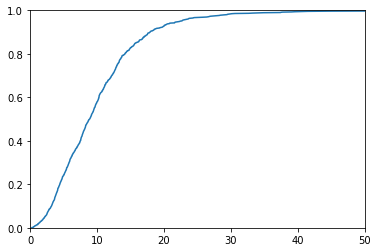

Train on 19937 samples
Epoch 1/10
19937/19937 [==============================] - 42s 2ms/sample - loss: 0.0019 - mse: 0.0019
Epoch 2/10
19937/19937 [==============================] - 42s 2ms/sample - loss: 0.0020 - mse: 0.0020
Epoch 3/10
 9984/19937 [==============>...............] - ETA: 20s - loss: 0.0021 - mse: 0.0021

In [ ]:


import pickle
for i in range(50):

    
    #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])
    model.fit(input_data,train_y,nb_epoch=10,batch_size=128,verbose = 1)
    test_pred_y = model.predict([test_id, test_rssi, test_building_id])
    test_pred_y = test_pred_y * ranges + bias 
    error_analysis(test_y, test_pred_y)
    file = open('lstm_2layer_result.txt','wb')
    pickle.dump(test_pred_y,file)
    file.close()

In [ ]:
for i in range(10):

    
    #model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss='mse', metrics=['mse'])s
    model.fit(input_data,train_y,nb_epoch=10,batch_size=128,verbose = 1)
    test_pred_y = model.predict([test_id, test_rssi, test_building_id])
    test_pred_y = test_pred_y * ranges + bias 
    error_analysis(test_y, test_pred_y)

In [ ]:
test_df = pd.read_csv(path_validation,header = 0)
print(test_df.head(2))
test_AP_strengths =test_df.loc[:,'WAP001':'WAP520']
#test_AP_features = np.array(test_AP_strengths.replace([100], [-100]))
test_building_ids_str = test_df["BUILDINGID"].map(str) #convert all the building ids to strings
test_building_floors_str = test_df["FLOOR"].map(str) #convert all the building floors to strings
#print(id_label)
test_floor_enc = LabelEncoder()
test_floor_enc.fit(building_floors_str)
test_floor_id = test_floor_enc.transform(test_building_floors_str)
test_floor_id = test_floor_id.reshape(-1,1)
print("test floor id",(test_floor_id.shape))
test_building_enc = LabelEncoder()
test_building_enc.fit(test_building_ids_str)
test_building_id = test_building_enc.transform(test_building_ids_str)
test_building_id = test_building_id.reshape(-1,1)
print("test building id:",(test_building_id.shape))
test_AP_features = np.array(test_AP_strengths.replace([100],[-100]))
test_id = np.argsort(test_AP_features)[:,500:520]
test_rssi = np.sort(test_AP_features)[:,500:520]

test_rssi_floor = np.hstack((test_rssi,test_floor_id))
print(test_rssi_floor[0], test_rssi_floor.shape)

test_df_LL = test_df.loc[:,'LONGITUDE':'LATITUDE']
test_y = np.asarray(test_df_LL)
test_pred_y = model.predict([test_id, test_rssi, test_building_id])
test_pred_y = test_pred_y * ranges + bias 
error_analysis(test_y, test_pred_y)

In [ ]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import np_utils
# fix random seed for reproducibility
numpy.random.seed(7)
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# prepare the dataset of input to output pairs encoded as integers
seq_length = 3
dataX = []
dataY = []
for i in range(0, len(alphabet) - seq_length, 1):
    seq_in = alphabet[i:i + seq_length]
    seq_out = alphabet[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
    #print(seq_in, '->', seq_out)
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (len(dataX), seq_length))
print(X.shape)
print(X[0])
# normalize
X = X / float(len(alphabet))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# create and fit the model
input_layer = L.Input(shape=(3,))
input_layer1 = L.Reshape((1, -1))(input_layer)
y = L.LSTM(32,return_sequences=False, activation='relu')(input_layer)
output_layer_1 = L.Dense(1, name='output')(y)
model = M.Model([input_layer], [output_layer_1])
model.fit(X, y, epochs=500, batch_size=1, verbose=2)
# summarize performance of the model
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))
# demonstrate some model predictions
for pattern in dataX:
    x = numpy.reshape(pattern, (1, 1, len(pattern)))
    x = x / float(len(alphabet))
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    print(seq_in, '->', seq_out)